In [2]:
from gibbs.dataclass import GibbsResult
import matplotlib.pyplot as plt
import numpy as np
from gibbs.learning.klocal_pauli_basis import KLocalPauliBasis
from gibbs.utils import number_of_elements
%load_ext autoreload
%autoreload 2


We start by loading the results of the preparation of the original hamiltonian and a perturbed hamiltonian by a control field. The idea is that we need to priorly know that when we prepare the two states, their faulty_hamiltonians are going to be very similar, and only differ by the control field with an error significantly smaller than the uncertainty we had on the original hamiltonian. We will use this field to pin down the rest of the coefficients of the hamiltoinan.
A good example of this would be an originally heisenberg Hamiltoinan, and then a control field that changes the coefficient on the single Pauli terms.

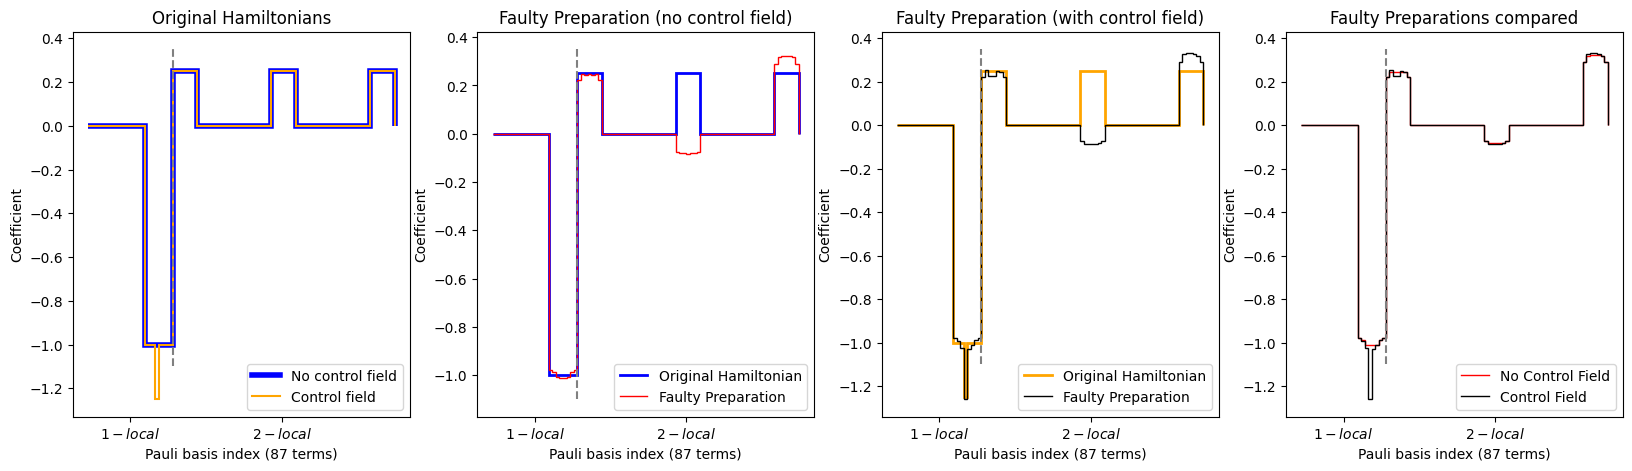

In [4]:
result_nocfield = GibbsResult.load(
    "saved_simulations/turbo/heisenberg_MAP/cfield=[]_date=21.01.2023_13:42:52.npy"
    )
# result_cfield = GibbsResult.load(
#     "saved_simulations/turbo/heisenberg_MAP/cfield=['0.25', 'ZIIIIIII', '0.25', 'IZIIIIII', '0.25', 'IIZIIIII', '0.25', 'IIIZIIII', '0.25', 'IIIIZIII', '0.25', 'IIIIIZII', '0.25', 'IIIIIIZI', '0.25', 'IIIIIIIZ']_date=22.01.2023_15:10:44.npy"
#     )

result_cfield = GibbsResult.load(
    "saved_simulations/turbo/heisenberg_MAP/cfield=['-0.25', 'IIIZIIII']_date=22.01.2023_15:26:13.npy"
)

func = np.real

loc1 = number_of_elements(1,result_cfield.num_qubits)
loc2 = number_of_elements(2,result_cfield.num_qubits)
fig,ax = plt.subplots(1,4,figsize=(20,5))
ax[0].stairs(func(result_nocfield.coriginal),lw=4, label="No control field",color = "blue")
ax[0].stairs(func(result_cfield.coriginal),linestyle = "-",lw=1.5, label="Control field",color = "orange")
ax[0].set_ylabel("Coefficient")
ax[0].set_title("Original Hamiltonians")
ax[0].legend(loc="lower right")

ax[1].stairs(func(result_nocfield.coriginal),lw=2, label="Original Hamiltonian",color = "blue")
ax[1].stairs(func(result_nocfield.cfaulties[-1]),linestyle = "-", label="Faulty Preparation",color = "red")
ax[1].set_xlabel("Pauli basis index")
ax[1].set_ylabel("Coefficient")
ax[1].set_title("Faulty Preparation (no control field)")
ax[1].legend(loc="lower right")

ax[2].stairs(func(result_cfield.coriginal),lw=2, label="Original Hamiltonian",color = "orange")
ax[2].stairs(func(result_cfield.cfaulties[-1]),linestyle = "-", label="Faulty Preparation",color = "black")
ax[2].set_xlabel("Pauli basis index")
ax[2].set_ylabel("Coefficient")
ax[2].set_title("Faulty Preparation (with control field)")
ax[2].legend(loc="lower right")

ax[3].stairs(func(result_nocfield.cfaulties[-1]),linestyle = "-", label="No Control Field",color = "red")
ax[3].stairs(func(result_cfield.cfaulties[-1]),linestyle = "-", label="Control Field",color = "black")
ax[3].set_xlabel("Pauli basis index")
ax[3].set_ylabel("Coefficient")
ax[3].set_title("Faulty Preparations compared")
ax[3].legend(loc="lower right")




for ax_label in ax:
    ax_label.set_ybound(-1.1,0.35)
    ax_label.vlines(number_of_elements(1,result_cfield.num_qubits),-1.1,0.35,linestyle = "--",color = "gray")
    ax_label.set_xticks((loc1//2,loc1+loc2//2))
    ax_label.set_xticklabels(('$1-local$', '$2-local$'), size='medium')
    ax_label.set_xlabel(f"Pauli basis index ({len(result_nocfield.coriginal)} terms)")



Text(0.5, 0, 'Pauli basis index (87 terms)')

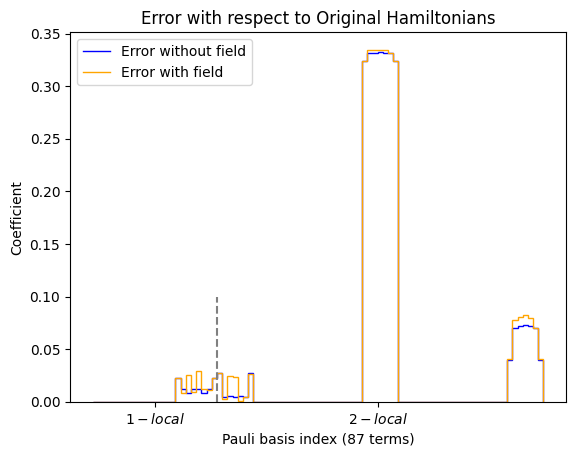

In [7]:
fig,ax = plt.subplots()
func = np.abs
index = -1
temp_offset = result_cfield.betas[-1]/result_cfield.betas[index]
ax.stairs(func(result_nocfield.coriginal / temp_offset-result_nocfield.cfaulties[index]),lw=1, label="Error without field",color = "blue")
ax.stairs(func(result_cfield.coriginal / temp_offset-result_cfield.cfaulties[index]),linestyle = "-",lw=1, label="Error with field",color = "orange")
ax.set_ylabel("Coefficient")
ax.set_title("Error with respect to Original Hamiltonians")
ax.legend(loc="upper left")
ax.vlines(number_of_elements(1,result_cfield.num_qubits),0,0.1,linestyle = "--",color = "gray")
ax.set_xticks((loc1//2,loc1+loc2//2))
ax.set_xticklabels(('$1-local$', '$2-local$'), size='medium')
ax.set_xlabel(f"Pauli basis index ({len(result_nocfield.coriginal)} terms)")


As we can see, both faulty hamiltonians are quite close to the expected state on the 1-local terms, and most of their error is concentrated onto the 2-local Pauli terms, specially in the YY term which is not captured at all by our ansatz. On top of that, when we compare the two faulty states we see that they are almost equivalent and their main difference is in the control field as we would expect.
An other thing to consider is the assumption we have made that the main source of error will correspond to k-local terms. If we plot the error of our state, we see that most of the error is concentrated in the k-local terms, with some error being filtered to 3-local and almost none to 4-local and above. This hints that in order to do proper reconstruction of our state it might be necessary to increase k, which would still scale well.

logm result may be inaccurate, approximate err = 3.4666003826961955e-13
logm result may be inaccurate, approximate err = 2.398847100562615e-13


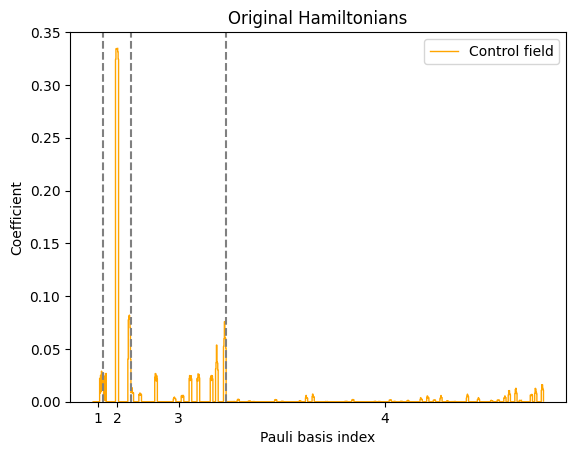

In [6]:
dictionary_toextend = result_cfield.__dict__.copy()
dictionary_toextend.pop("cfaulties")
dictionary_toextend["klocality"] = 4
extended_result = GibbsResult(**dictionary_toextend)
loc1 = number_of_elements(1,result_cfield.num_qubits)
loc2 = number_of_elements(2,result_cfield.num_qubits)
loc3 = number_of_elements(3,result_cfield.num_qubits)
loc4 = number_of_elements(4,result_cfield.num_qubits)
fig,ax = plt.subplots()
diff = extended_result.cfaulties[-1].copy()
diff[:len(extended_result.coriginal)] -= extended_result.coriginal
diff =np.abs(diff)
ax.stairs(diff,linestyle = "-",lw=1, label="Control field",color = "orange")

ax.set_xlabel("Pauli basis index")
ax.set_ylabel("Coefficient")
ax.set_title("Original Hamiltonians")
ax.legend(loc="upper right")
ax.set_xticks((loc1/2,loc1+loc2//2,loc1+loc2+loc3//2,loc1+loc2+loc3+loc4//2))
ax.set_xticklabels(('$1$', '$2$','3',"4"), size='medium')

ax.vlines([loc1,loc1+loc2,loc1+loc2+loc3],0,0.35,linestyle = "--",color = "gray")
ax.set_ybound(0,0.35)

Now that we have stablished the noise model -remember that so far we haven't added noise to the measurements during the state preparation, and the noise that we have so far is purely due to integration errors and poorly chosen ansatz- we can start to estimate the coefficients of our faulty hamiltonian.
Start by noting that:
* The original faulty Hamiltonian in the k-local basis will be $c_0 = c_{original} + c_{error}$
* When adding a control field we will have $c_1 = c_{original} + c_{error} + c_{error}^1$
* $c_{error}$ is much bigger than $c_{error}^1$


We need a field not only that we know that we can track well, but also that we know that won't disturb by much the Hamiltonian. I don't know if it is possible to model the noise that adding a field will provoke to the rest of the terms of the faulty Hamiltonian when preparing the state, or if it would be better to just add that as a random noise.

Now we will build the initial prior.

In [9]:
result = result_cfield
#This should be x =( c.T , v.T ) with v being the pertinent field
x_bar = np.append((result_nocfield.coriginal,result_cfield.coriginal-result_nocfield.coriginal))

Gamma_c = np.diag(np.ones(len(result_cfield.coriginal))) * 1e-1 #Here we could even change the value depending on the locality.
Gamma_v = np.diag(np.ones(len(result_cfield.coriginal))) * 1e-2 #Same here


(9.375+0j)